In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import itertools as it
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import KFold

from config_file import *

In [5]:
smartwatch_dataset = pd.read_csv('Data//Garmin Smart watch placed on the rist//max_speed_garmin_clock.csv')
smartwatch_dataset.dropna(axis=1, how='all')
print(smartwatch_dataset)

       Laps     Time Cumulative Time  Distance  Avg Speed  Avg HR  Max HR  \
0         1  03:55.1         03:55.1      1.61       24.6     116     125   
1         2  03:23.4         07:18.5      1.61       28.5     107     112   
2         3  03:37.6           10:56      1.61       26.6     112     131   
3         4  03:21.4           14:17      1.61       28.8     110     116   
4         5  02:27.8           16:45      1.61       39.2     104     116   
5         6  06:16.8           23:02      1.61       15.4     109     115   
6         7  04:37.6        27:40:00      1.61       20.9     122     134   
7         8    10:16        37:56:00      1.61        9.4     104     125   
8         9  03:24.1        41:20:00      1.61       28.4     108     117   
9        10  04:43.6        46:03:00      1.61       20.4     106     113   
10       11  06:30.1        52:34:00      1.61       14.9     100     112   
11       12  02:31.6        55:05:00      1.61       38.2     106     113   

In [2]:
_print_plots = False

# Figure size in inches
rcParams['figure.figsize'] = 11,8

# Load the datasets:
#   wings_DIC_results: wing's slopes and intercepts
#   measurements_subset: windboard force measuremeants, sourced in Windsurfer_Regression.ipynb
#   location_dataset: Used to compare trim (fore/aft) with measurements scores

%store -r measurements_subset
%store -r norm_wings_dic_df
wings_jul22_dataset = norm_wings_dic_df
masts_jul22_dataset = measurments_subset
location_dataset = pd.read_csv('Data//gps_location.csv')

print(wings_jul22_dataset)
print(measurements_subset)
print(location_dataset)

          bend slopes_1  bend slopes_2  bend slopes_3  bend slopes_4  \
itemName                                                               
DP2            0.474576       0.144672       0.473061       0.117890   
MM3            0.659969       0.515439       0.634003       0.607555   
MM4            0.444614       0.266712       0.334752       0.351196   
NG1            0.500593       0.340951       0.462963       0.441396   
NM1            0.000000       0.597290       0.000000       0.593629   
NM2            0.455417       0.211991       0.399988       0.179938   
SK3            0.535796       0.241127       0.503117       0.152317   
ST2            0.623792       0.503806       0.655743       0.675879   
ST3            0.212471       0.197529       0.262755       0.135784   
TR3            1.000000       1.000000       0.970789       1.000000   
TR4            0.715299       0.611970       0.726804       0.628955   
TR5            0.621474       0.448179       0.613004       0.34

In [18]:

itemNames = list(wings_jul22_dataset.index.values)
conditions = [
    ('DP' in itemNames),  # Daniela Peleg
    ('MM' in itemNames),  # Maya Morris
    ('NG' in itemNames),
    ('NM' in itemNames),
    ('SK' in itemNames),  # Sharon Kantor
    ('ST' in itemNames),
    ('TR' in itemNames),  # Tom Reuveny
    ('TV' in itemNames),
    ('YC' in itemNames),
    ('YO' in itemNames)
]

In [3]:
# Creating labels

#  Initialize conditions according the surfer's name
conditions = [
    ('DP' in wings_jul22_dataset['itemName']),  # Daniela Peleg
    ('MM' in wings_jul22_dataset['itemName']),  # Maya Morris
    ('NG' in wings_jul22_dataset['itemName']),
    ('NM' in wings_jul22_dataset['itemName']),
    ('SK' in wings_jul22_dataset['itemName']),  # Sharon Kantor
    ('ST' in wings_jul22_dataset['itemName']),
    ('TR' in wings_jul22_dataset['itemName']),  # Tom Reuveny
    ('TV' in wings_jul22_dataset['itemName']),
    ('YC' in wings_jul22_dataset['itemName']),
    ('YO' in wings_jul22_dataset['itemName'])
]

#  Calculate avg speed/max speed from surfer files
#  NEED TO COMPLETE FROM RELEVANT GARMIN DATA WHICH IS CURRENTLY MISSING
avg_speed = [0 for i in range(len(conditions))]
max_speed = [0 for i in range(len(conditions))]

wings_jul22_dataset['avg_speed'] = np.select(conditions, avg_speed)
wings_jul22_dataset['max_speed'] = np.select(conditions, max_speed)

KeyError: 'itemName'

In [19]:
# Splitting into feature groups
bend_slopes = wings_jul22_dataset[['bend slopes_1','bend slopes_2','bend slopes_3','bend slopes_4']]
bend_intercepts = wings_jul22_dataset[['bend intercepts_1','bend intercepts_2','bend intercepts_3','bend intercepts_4']]
twistBack_slopes = wings_jul22_dataset[['twistBack slopes_1','twistBack slopes_2','twistBack slopes_3','twistBack slopes_4']]
twistBack_intercepts = wings_jul22_dataset[['twistBack intercepts_1','twistBack intercepts_2','twistBack intercepts_3','twistBack intercepts_4']]
twistFront_slopes = wings_jul22_dataset[['twistFront slopes_1','twistFront slopes_2','twistFront slopes_3','twistFront slopes_4']]
twistFront_intercepts = wings_jul22_dataset[['twistFront intercepts_1','twistFront intercepts_2','twistFront intercepts_3','twistFront intercepts_4']]

slopes = [bend_slopes, twistBack_slopes, twistFront_slopes]
intercepts = [bend_intercepts, twistBack_intercepts, twistFront_intercepts]

In [20]:
if _print_plots:
    #compare group features with group features
    for slope_index in slopes:
        for intercept_index in intercepts:
            rel = sns.pairplot(wings_jul22_dataset[[elem for elem_i in [slope_index.columns, intercept_index.columns] for elem in elem_i]],
                         diag_kind='kde',
                         x_vars=wings_jul22_dataset[slope_index.columns],
                         y_vars=wings_jul22_dataset[intercept_index.columns],
                         height=2)
            rel.fig.subplots_adjust(top=.95)
            rel.fig.suptitle(f"Pairplot of {slope_index.columns[0][:-2]} and {intercept_index.columns[0][:-2]}")
            plt.show()

In [21]:
if _print_plots:
    for pair in it.combinations(slopes, 2):
        df_for_pair = wings_jul22_dataset[[elem for elem_i in pair for elem in elem_i]]
        rel = sns.pairplot(df_for_pair,
                           diag_kind='kde',
                           x_vars=wings_jul22_dataset[pair[0].columns],
                           y_vars=wings_jul22_dataset[pair[1].columns])
        rel.fig.subplots_adjust(top=.95)
        rel.fig.suptitle(f"Pairplot of {pair[0].columns[0][:-2]} and {pair[1].columns[0][:-2]}")
        plt.show()

In [22]:
if _print_plots:
    for pair in it.combinations(intercepts, 2):
        rel = sns.pairplot(wings_jul22_dataset[[elem for elem_i in pair for elem in elem_i]],
                           diag_kind='kde',
                           x_vars=wings_jul22_dataset[pair[0].columns],
                           y_vars=wings_jul22_dataset[pair[1].columns])
        rel.fig.subplots_adjust(top=.95)
        rel.fig.suptitle(f"Pairplot of {pair[0].columns[0][:-2]} and {pair[1].columns[0][:-2]}")
        plt.show()

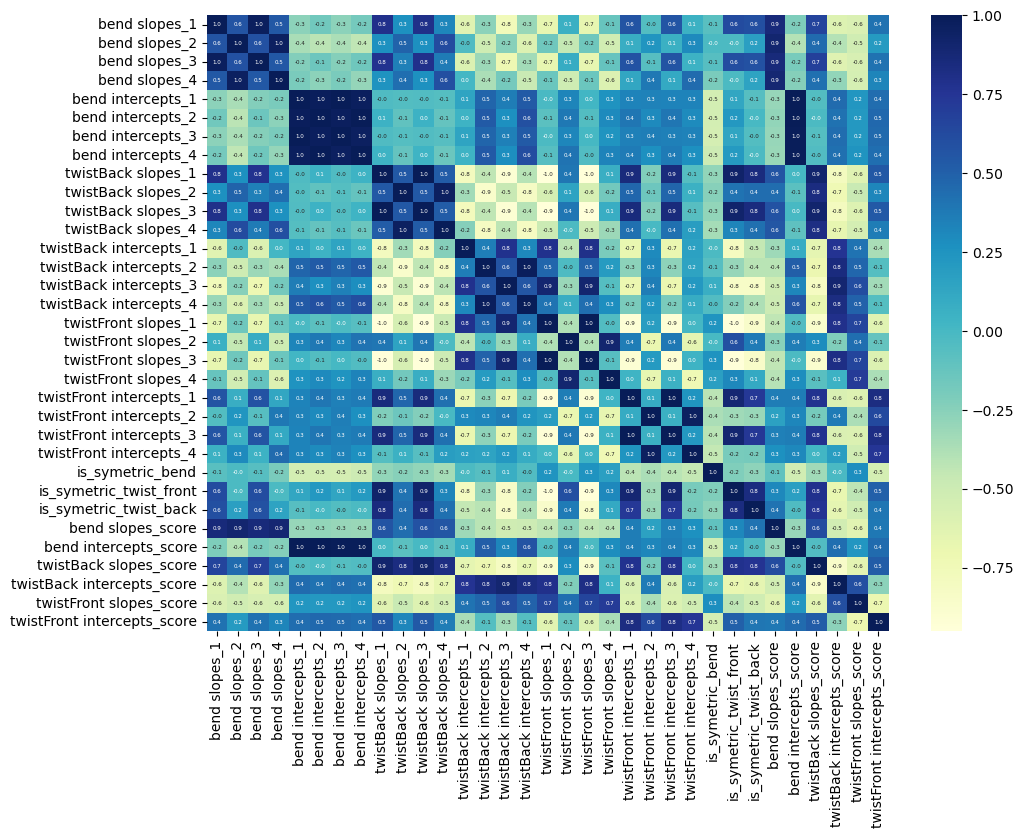

In [27]:
#wings_df_without_speed = wings_jul22_dataset.drop(columns=['avg_speed','max_speed'])
wings_df_without_speed = wings_jul22_dataset
sns.heatmap(wings_df_without_speed.corr(), annot=True, cmap="YlGnBu",annot_kws={"fontsize":4}, fmt=".1f")
plt.show()

In [3]:
splits = 10

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def build_and_compile_model(lr, model, inputs, targets):
    acc_per_fold = []
    loss_per_fold = []
    histories = []
    fold_no = 1
    kf = KFold(n_splits=splits)
    for train, test in kf.split(inputs, targets):
        model.compile(
            # Test different learning rates and print results
            optimizer=tf.optimizers.Adam(learning_rate=lr),
            loss="mean_squared_error",
            metrics=[soft_acc]
        )
        histories.append(model.fit(inputs[train], targets[train], epochs=60, verbose=0))
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    return (histories, loss_per_fold, acc_per_fold)


def compile_model(model, inputs, targets, lr_list, best_lr=None):
    results = []
    for lr in lr_list:
        if best_lr is not None:
            results.append(build_and_compile_model(best_lr, model, inputs, targets))
            print(model.summary())
            scores_per_fold(results)
            break
        print(f"Current lr: {round(lr, 10)}")
        results.append(build_and_compile_model(round(lr, 10), model, inputs, targets))
    return results


def scores_per_fold(results):
    if _best_lr is not None:
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(len(results[0][2])):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i + 1} - Loss: {results[0][1][i]} - Accuracy: {results[0][2][i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Accuracy: {np.mean(results[0][2])} (+- {np.std(results[0][2])})')
        print(f'> Loss: {np.mean(results[0][1])}')
        print('------------------------------------------------------------------------')


def show_nine_losses(results, lr_list, title=""):
    fig, axs = plt.subplots(3, 3, figsize=(10, 6))
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=16, y=1.05)
    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        avg_loss_per_epoch = [0 for i in range(len(results[0][0][0].history['loss']))]  #epochs
        for hist in results[i][0]:
            avg_loss_per_epoch = [x + y for x, y in zip(avg_loss_per_epoch, hist.history['loss'])]
        avg_loss_per_epoch = [x / len(results[0][0]) for x in avg_loss_per_epoch]
        axs[i].plot(avg_loss_per_epoch, label='loss')
        axs[i].set_title(f'lr={round(lr, 8)}')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
        axs[i].grid(True)
    plt.show()


def show_single_loss(results, lr, title="", legend='loss'):
    fig, ax = plt.subplots(figsize=(10, 6))
    avg_loss_per_epoch = [0 for i in range(len(results[0][0][0].history['loss']))]
    for hist in results[0][0]:
        avg_loss_per_epoch = [x + y for x, y in zip(avg_loss_per_epoch, hist.history['loss'])]
    avg_loss_per_epoch = [x / len(results[0][0]) for x in avg_loss_per_epoch]
    plt.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.05)
    ax.plot(avg_loss_per_epoch, label='loss')
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(title=legend)
    ax.grid(True)
    plt.show()

In [ ]:
# Before running model, complete speed values (at the top)

In [30]:
print(slopes)

[          bend slopes_1  bend slopes_2  bend slopes_3  bend slopes_4
itemName                                                            
DP2            0.474576       0.144672       0.473061       0.117890
MM3            0.659969       0.515439       0.634003       0.607555
MM4            0.444614       0.266712       0.334752       0.351196
NG1            0.500593       0.340951       0.462963       0.441396
NM1            0.000000       0.597290       0.000000       0.593629
NM2            0.455417       0.211991       0.399988       0.179938
SK3            0.535796       0.241127       0.503117       0.152317
ST2            0.623792       0.503806       0.655743       0.675879
ST3            0.212471       0.197529       0.262755       0.135784
TR3            1.000000       1.000000       0.970789       1.000000
TR4            0.715299       0.611970       0.726804       0.628955
TR5            0.621474       0.448179       0.613004       0.344701
TV1            0.504932       0.1

In [4]:
lr_list = np.logspace(-9, -1, 9)
_best_lr = None
#_best_lr = 0.003

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
])

test_results = []
losses = []

surfer_targets = wings_jul22_dataset['max_speed']
surfer_inputs = wings_jul22_dataset.remove(surfer_targets)

surfer_results = compile_model(model, surfer_inputs, surfer_targets, lr_list, _best_lr)
if _best_lr is not None:
    show_single_loss(surfer_results, _best_lr)
else:
    show_nine_losses(surfer_results, lr_list)

KeyError: 'max_speed'